## Importing libraries 

In [2]:
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Loading data

The data set contains 2 folders, one for training images and the other is for test images. Inside each folder there's a folder for each car type contining images for that type.

In [3]:
train_folder = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
test_folder = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'

We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

The `ImageFolder` class is part of PyTorch's `torchvision` module, specifically designed for working with image datasets. It assumes that the images are organized in folders, where each folder represents a class or category. 

The `transform` parameter specifies the transformations to be applied to the images

In [64]:
train_data = ImageFolder(train_folder , transform = ToTensor())
test_data = ImageFolder(test_folder , transform = ToTensor())

Each element in `train_data` and `test_data`is a tuple of 2 elements, the image and its label. The label is derived automatically from the subdirectory structure. The list of classes is stored in the `.classes` property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [65]:
print("Number of images in the training data: " , len(train_data))
print("Number of images in the test data: " , len(test_data))

Number of images in the training data:  8144
Number of images in the test data:  8041


## Data Understanding

Let's look at some images in our data

In [6]:
train_data[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 0)

Let's look at the shape of this image

In [7]:
train_data[0][0].shape

torch.Size([3, 525, 700])

3 represents the number of color channels (RGB) and the other 2 numbers are the dimensions of the image. Let's look at another image

In [8]:
train_data[2000], train_data[2000][0].shape

((tensor([[[0.7804, 0.7333, 0.7373,  ..., 0.6706, 0.6627, 0.6784],
           [0.7333, 0.6863, 0.6863,  ..., 0.6275, 0.6157, 0.6314],
           [0.7373, 0.6902, 0.6941,  ..., 0.6353, 0.6235, 0.6431],
           ...,
           [0.7451, 0.7098, 0.7216,  ..., 0.7059, 0.7098, 0.7176],
           [0.7294, 0.6941, 0.7137,  ..., 0.6824, 0.6941, 0.7098],
           [0.7608, 0.7255, 0.7412,  ..., 0.6980, 0.7216, 0.7490]],
  
          [[0.9059, 0.8588, 0.8627,  ..., 0.7412, 0.7255, 0.7412],
           [0.8588, 0.8118, 0.8118,  ..., 0.6980, 0.6784, 0.6941],
           [0.8627, 0.8157, 0.8196,  ..., 0.7059, 0.6863, 0.7059],
           ...,
           [0.7255, 0.6902, 0.7020,  ..., 0.6745, 0.6784, 0.6863],
           [0.7098, 0.6745, 0.6941,  ..., 0.6510, 0.6627, 0.6784],
           [0.7412, 0.7059, 0.7216,  ..., 0.6667, 0.6902, 0.7176]],
  
          [[0.9961, 0.9490, 0.9529,  ..., 0.7961, 0.7843, 0.8000],
           [0.9490, 0.9020, 0.9020,  ..., 0.7529, 0.7373, 0.7529],
           [0.9529, 0.

This image has different dimensions. Since images have different dimensions we will need to resize them to have the same image size across all images so we can then give them to a model. Now let's view some images, we will define a function to show us examples from training and testing data

In [9]:
def show_rand_img(data):
    img , label = random.choice(data)
    plt.title(data.classes[label])
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

Showing a random image from training and test data: 

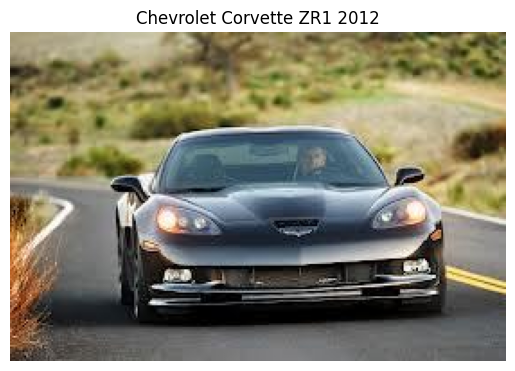

In [10]:
show_rand_img(train_data)

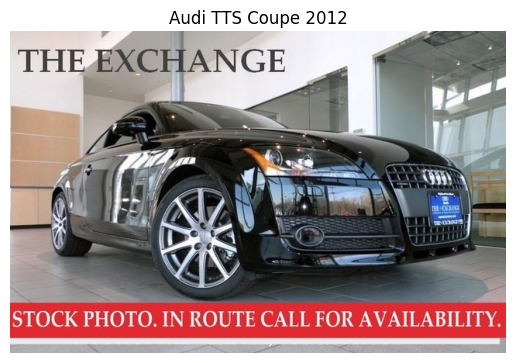

In [11]:
show_rand_img(test_data)

## Data Transformation

As we mentiond before the images in our data have different dimensions, we will resize all the images in the train and test data to have a size of `256x256`. This is useful because neural networks expect input data of a fixed size. also using fixed-size images allows for more efficient batch processing during training, as all images in a batch have the same shape. 

In addition to resizing images, we will normalize them to bring the pixel values into a standardized range. Normalizing pixel values helps in stabilizing the training process. Neural networks often converge faster and more reliably when the input data has a consistent scale

In [66]:
tfms = tt.Compose([
    tt.Resize((256 , 256)),
    tt.ToTensor(),
    tt.Normalize((0.5 , 0.5 , 0.5), (0.5 , 0.5 , 0.5))
])

train_data = ImageFolder(train_folder , transform = tfms)
test_data = ImageFolder(test_folder , transform = tfms)

- `tt.Compose` allows as to compose multiple image transforms

- `tt.Resize((256, 256))`: Resizes the image to a fixed size of 256x256 pixels.

- `tt.ToTensor()`: Converts the image to a PyTorch tensor. This is necessary as PyTorch works with tensors.

- `tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`: Normalizes the tensor values to have a mean of 0.5 and a standard deviation of 0.5 for each channel

Showing images after resizing and normalization:

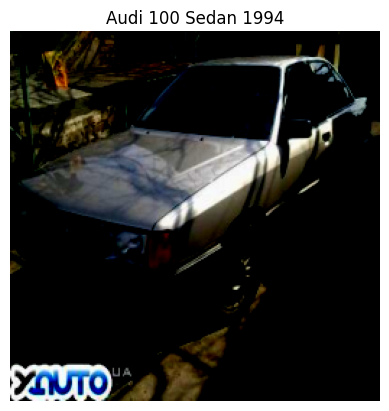

In [13]:
show_rand_img(train_data)

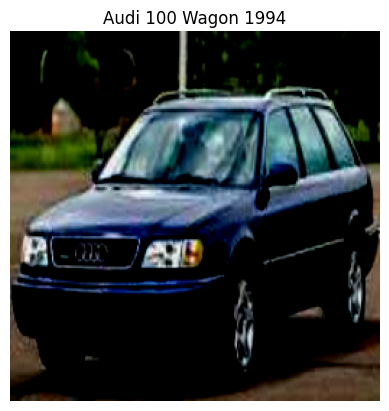

In [14]:
show_rand_img(test_data)

## Creating a validation set

We will randomly sample 10% of the training data to be used as a validation set

In [67]:
random_seed = 42
torch.manual_seed(random_seed)
val_percent = 0.1
val_size = int(val_percent * len(train_data))
train_size = len(train_data) - val_size
train_data, val_data = random_split(train_data, [train_size, val_size])

In [68]:
print("Number of images in the training data: " , len(train_data))
print("Number of images in the validation data: " , len(val_data))

Number of images in the training data:  7330
Number of images in the validation data:  814


Creating data loaders for train and validation data so that they're loaded in batches

In [70]:
batch_size = 128
train_dl = DataLoader(train_data , batch_size = batch_size,shuffle = True , num_workers = 4 , pin_memory = True)
val_dl = DataLoader(val_data , batch_size = batch_size * 2, num_workers = 4 , pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

- `DataLoader`: a PyTorch utility that helps with efficient loading of datasets during training.

- `batch_size`: a parameter that determines the number of data samples processed in one iteration during training. 

- `shuffle = True`: For the training DataLoader setting shuffle to True means that the order of data samples in each batch will be randomized during training. This helps the model generalize better by preventing it from learning patterns based on the order of the data.

- `num_workers = 4`: num_workers is the number of parallel processes used for loading data. It can speed up data loading by loading batches concurrently.

- `pin_memory = True`: This is set to True for both train_dl and val_dl. When pin_memory is enabled, the DataLoader will attempt to use pinned memory for faster data transfer to GPU. This is beneficial when training deep learning models on a GPU.

- `batch_size * 2` for val_dl: For the validation DataLoader (val_dl), the batch size is set to twice the value used for training. This is a common practice to speed up validation by using larger batches, as validation doesn't involve backpropagation, and larger batches can be processed more efficiently.

looking at batches of images from the dataset using the `make_grid` method from `torchvision`:

In [18]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12,6))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

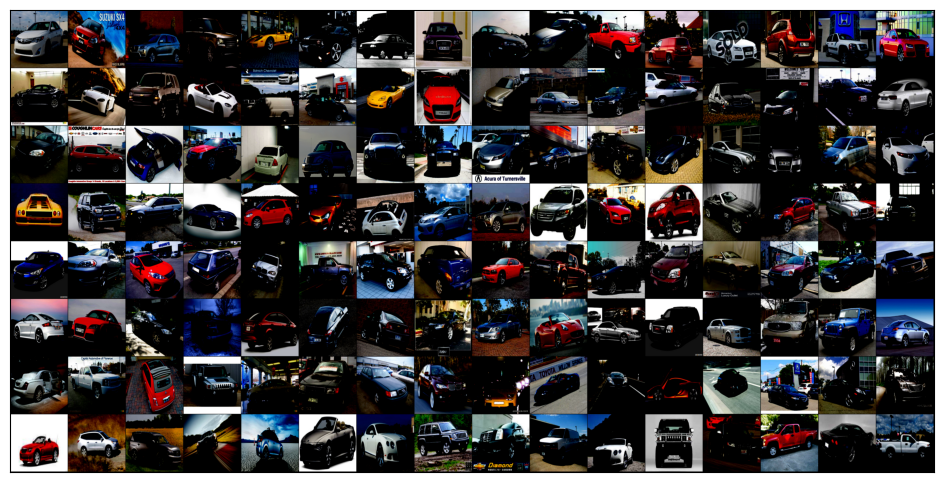

In [19]:
show_batch(train_dl)

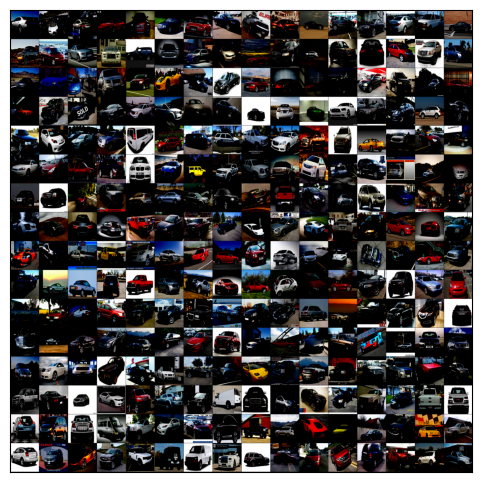

In [20]:
show_batch(val_dl)

## Training a convolutional neural network model

We will start by defining a base class for a model that includes methods like `training_step`, `validation_step`, `validation_epoch_end`, and other custom methods. Then the model that we will build will inherit from this class. This design pattern is often used to organize and encapsulate the training and evaluation logic of a model in a modular and readable way.

In [21]:
class BaseClassifier(nn.Module):
    def training_step(self , batch):
        images , labels = batch
        predictions = self(images)
        loss = F.cross_entropy(predictions , labels)
        return loss
    
    def validation_step(self , batch):
        images , labels = batch
        predictions = self(images)
        loss = F.cross_entropy(predictions , labels)
        acc = accuracy(predictions , labels)
        return {'val_loss': loss.detach() , 'val_accuracy': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = torch.tensor([x['val_loss'] for x in outputs])
        epoch_loss = torch.mean(batch_losses)
        batch_accs = torch.tensor([x['val_accuracy'] for x in outputs])
        epoch_acc = torch.mean(batch_accs)
        return {'val_loss': epoch_loss.item(), 'val_accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch_num, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch_num, result['train_loss'], result['val_loss'], result['val_accuracy']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
class CNNCarClassifier(BaseClassifier):
    def __init__(self):
        super(CNNCarClassifier , self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(64*32*32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 196))
        
    def forward(self, input_imgs):
        return self.network(input_imgs)

In [23]:
model = CNNCarClassifier()
model

CNNCarClassifier(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=65536, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

 We will use a GPU to accelerate the training of our models.To use a GPU, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. 

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cuda')

using `DeviceDataLoader` to automatically transferring batches of data to the GPU (if available).

In [71]:
train_dl = DeviceDataLoader(train_dl , device)
val_dl = DeviceDataLoader(val_dl , device)
test_dl = DeviceDataLoader(test_dl , device)

functions to fit and evaluate the model:

In [72]:
def evaluate(model , val_dl):
    model.eval()
    with torch.no_grad():
        outputs = [model.validation_step(batch) for batch in val_dl]
    
    return model.validation_epoch_end(outputs)

def fit(model , train_dl , val_dl ,num_epochs, learning_rate , opt_func):
        history = []
        optimizer = opt_func(model.parameters() , learning_rate)
        
        for epoch in range(num_epochs):
            model.train()
            train_losses = []
            
            for batch in train_dl:
                loss = model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            result = evaluate(model , val_dl)
            result['train_loss'] = torch.mean(torch.tensor(train_losses)).item()
            model.epoch_end(epoch , result)
            history.append(result)
        
        return history

training the model:

In [77]:
model = to_device(CNNCarClassifier() , device)

In [78]:
history = fit(model , train_dl , val_dl , num_epochs = 10 , learning_rate = 0.05 , opt_func = torch.optim.Adam)

Epoch [0], train_loss: 196978.3750, val_loss: 5.3011, val_acc: 0.0010
Epoch [1], train_loss: 5.2988, val_loss: 5.2947, val_acc: 0.0226
Epoch [2], train_loss: 5.2943, val_loss: 5.2929, val_acc: 0.0029
Epoch [3], train_loss: 5.2923, val_loss: 5.2897, val_acc: 0.0226
Epoch [4], train_loss: 5.2911, val_loss: 5.2886, val_acc: 0.0226
Epoch [5], train_loss: 5.2915, val_loss: 5.2963, val_acc: 0.0226
Epoch [6], train_loss: 5.2917, val_loss: 5.2919, val_acc: 0.0226
Epoch [7], train_loss: 5.2918, val_loss: 5.2907, val_acc: 0.0226
Epoch [8], train_loss: 5.2900, val_loss: 5.2906, val_acc: 0.0226
Epoch [9], train_loss: 5.2912, val_loss: 5.2949, val_acc: 0.0029


Plotting accuracies and losses:

In [79]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

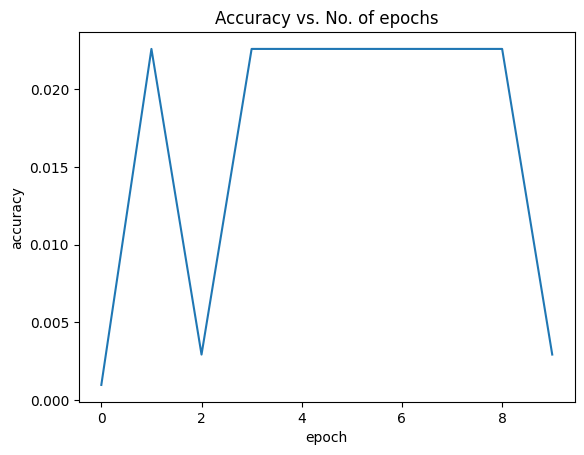

In [80]:
plot_accuracies(history)

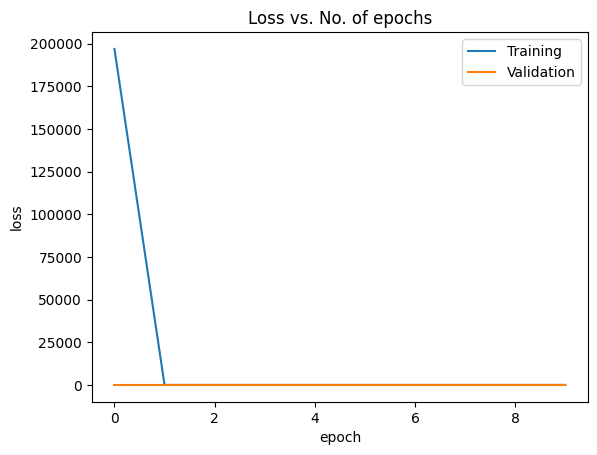

In [81]:
plot_losses(history)

Evlauating on the test set

In [82]:
evaluate(model , test_dl)

{'val_loss': 5.304764270782471, 'val_accuracy': 0.0057043652050197124}

Looks like this model is performing poorly, we will try to add batch normalization and dropout layers and see if that increases the accuracy.

## Adding Addtional layers and Batch Normalization and Dropout layers

In [83]:
class CNNCarClassifier2(BaseClassifier):
    def __init__(self):
        super(CNNCarClassifier2, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 196)
        )

    def forward(self, input_imgs):
        return self.network(input_imgs)

In [84]:
model2 = to_device(CNNCarClassifier2() , device)

In [85]:
history = fit(model2 , train_dl , val_dl , num_epochs = 10 , learning_rate = 0.01 , opt_func = torch.optim.Adam)

Epoch [0], train_loss: 9.4720, val_loss: 5.2843, val_acc: 0.0010
Epoch [1], train_loss: 5.3387, val_loss: 5.2859, val_acc: 0.0226
Epoch [2], train_loss: 5.2843, val_loss: 5.2877, val_acc: 0.0226
Epoch [3], train_loss: 5.2774, val_loss: 5.2886, val_acc: 0.0226
Epoch [4], train_loss: 5.2795, val_loss: 5.2886, val_acc: 0.0226
Epoch [5], train_loss: 5.2928, val_loss: 5.2893, val_acc: 0.0226
Epoch [6], train_loss: 5.3539, val_loss: 5.2881, val_acc: 0.0226
Epoch [7], train_loss: 5.2779, val_loss: 5.2890, val_acc: 0.0226
Epoch [8], train_loss: 5.2988, val_loss: 5.2896, val_acc: 0.0226
Epoch [9], train_loss: 5.2759, val_loss: 5.2901, val_acc: 0.0226


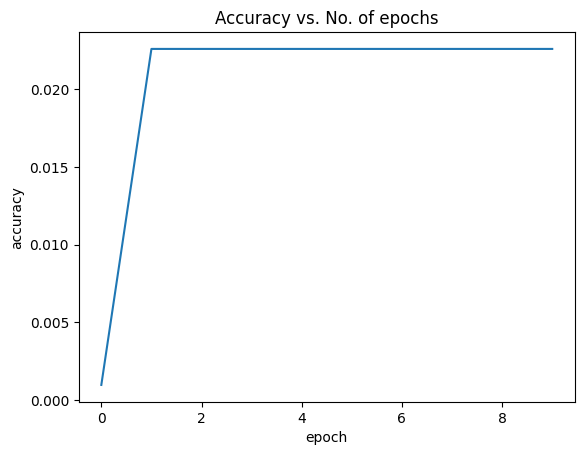

In [86]:
plot_accuracies(history)

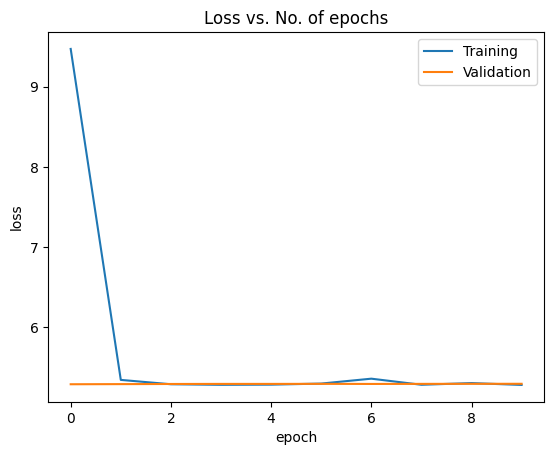

In [87]:
plot_losses(history)

Evaluating on the test set

In [88]:
evaluate(model2 , test_dl)

{'val_loss': 5.274054527282715, 'val_accuracy': 0.008432540111243725}

Again this model performs poorly, let's try to take a different approach.

## Transfer Learning

Since the model we build from scratch had bad results, we will try to use a pretrained model and fine-tune it for our task. We will use the pretrained `ResNet34` model.

In [89]:
from torchvision import models

class StanfordCarsModel(BaseClassifier):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.network = models.resnet34(pretrained=pretrained)
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [90]:
model = to_device(StanfordCarsModel(len(test_data.classes)) , device)
model

StanfordCarsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [91]:
history = fit(model , train_dl , val_dl , num_epochs = 10 , learning_rate = 0.001 , opt_func = torch.optim.Adam)

Epoch [0], train_loss: 4.4986, val_loss: 4.7493, val_acc: 0.0725
Epoch [1], train_loss: 2.7061, val_loss: 2.8315, val_acc: 0.2690
Epoch [2], train_loss: 1.5945, val_loss: 3.3415, val_acc: 0.2523
Epoch [3], train_loss: 0.9291, val_loss: 3.3569, val_acc: 0.3108
Epoch [4], train_loss: 0.4921, val_loss: 1.9092, val_acc: 0.4972
Epoch [5], train_loss: 0.2870, val_loss: 1.4662, val_acc: 0.5798
Epoch [6], train_loss: 0.1802, val_loss: 1.4855, val_acc: 0.5983
Epoch [7], train_loss: 0.1207, val_loss: 1.5446, val_acc: 0.5941
Epoch [8], train_loss: 0.0764, val_loss: 1.5967, val_acc: 0.6021
Epoch [9], train_loss: 0.0545, val_loss: 1.1638, val_acc: 0.6979


Plotting the accuracy and losses

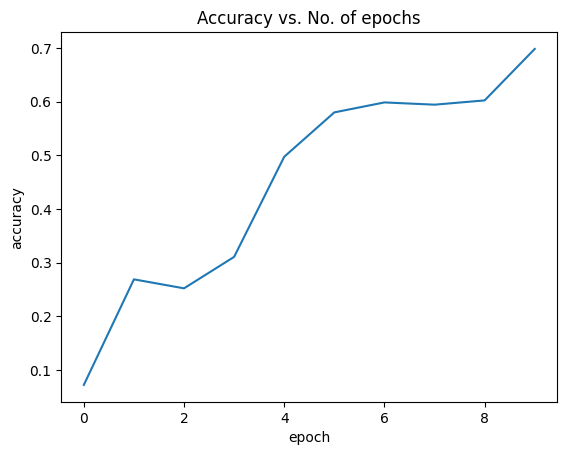

In [95]:
plot_accuracies(history)

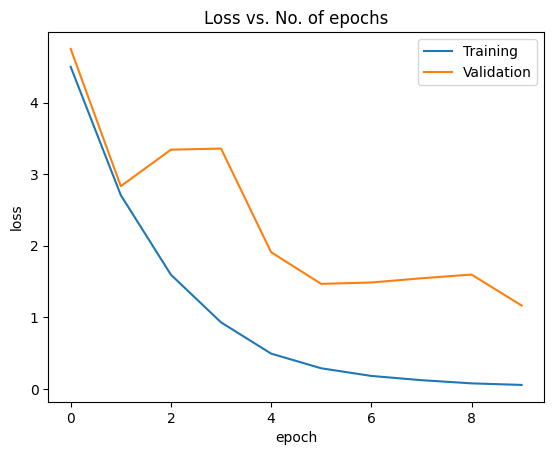

In [96]:
plot_losses(history)

Evaluating on the test set

In [94]:
evaluate(model , test_dl)

{'val_loss': 3.231062173843384, 'val_accuracy': 0.35531580448150635}

This model performs much better than the previous ones. We will try to improvment this model to get better accuracy.

## Improving the pretrained model

#### Data augmentation

In [112]:
stats = ((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
train_tfms = tt.Compose([tt.Resize((256, 256)),
                         tt.RandomRotation(0),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace = True)])
valid_tfms = tt.Compose([tt.Resize((256, 256)),
                        tt.ToTensor(),
                        tt.Normalize(*stats)])

In [113]:
train_dataset = ImageFolder(train_folder, train_tfms)
valid_dataset = ImageFolder(test_folder, valid_tfms)
test_dataset = ImageFolder(test_folder, train_tfms)

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl , device)

In [114]:
model = to_device(StanfordCarsModel(len(test_data.classes)) , device)

In [115]:
history = fit(model , train_dl , val_dl , num_epochs = 10 , learning_rate = 0.001 , opt_func = torch.optim.Adam)

Epoch [0], train_loss: 4.1863, val_loss: 4.4055, val_acc: 0.1060
Epoch [1], train_loss: 2.2018, val_loss: 2.7314, val_acc: 0.2898
Epoch [2], train_loss: 1.1668, val_loss: 1.9827, val_acc: 0.4756
Epoch [3], train_loss: 0.6538, val_loss: 1.0492, val_acc: 0.7091
Epoch [4], train_loss: 0.3709, val_loss: 1.0804, val_acc: 0.6681
Epoch [5], train_loss: 0.2152, val_loss: 1.0372, val_acc: 0.6953
Epoch [6], train_loss: 0.1458, val_loss: 0.7213, val_acc: 0.7840
Epoch [7], train_loss: 0.0922, val_loss: 0.5374, val_acc: 0.8516
Epoch [8], train_loss: 0.0603, val_loss: 0.3015, val_acc: 0.9029
Epoch [9], train_loss: 0.0513, val_loss: 0.2192, val_acc: 0.9452


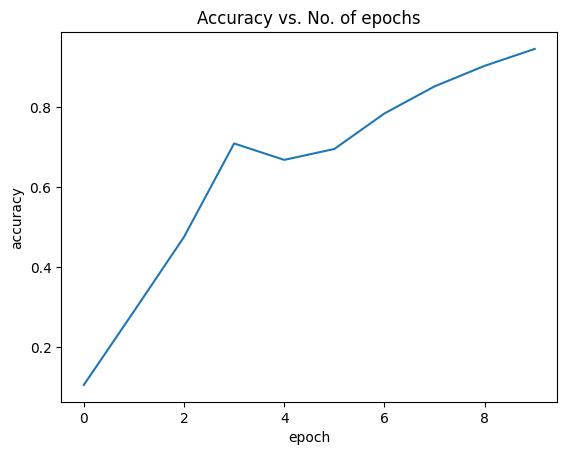

In [116]:
plot_accuracies(history)

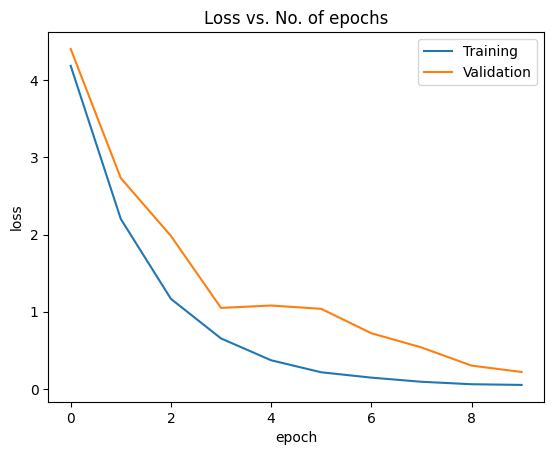

In [117]:
plot_losses(history)

In [118]:
evaluate(model , test_dl)

{'val_loss': 1.224719762802124, 'val_accuracy': 0.689610481262207}